# 07. Training and Evaluation Patterns

This notebook covers the essential patterns and best practices for training and evaluating PyTorch models. You'll learn how to structure training loops, handle different phases of training, implement proper evaluation, and debug common issues.

By the end of this notebook, you'll understand:

- How to structure robust training loops
- Proper model evaluation techniques
- Training and validation phases
- Model checkpointing and saving
- Performance monitoring and visualization
- Common debugging techniques
- Early stopping and regularization

**Why is this important?**

Proper training and evaluation patterns are crucial for:

- Reliable model development
- Avoiding common pitfalls like overfitting
- Reproducible results
- Efficient debugging and experimentation


## Setting Up the Environment

Let's start by importing necessary libraries and setting up our environment:


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
import time
import copy
from collections import defaultdict
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up device
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")

# Create directory for saving models
os.makedirs("models", exist_ok=True)

print(f"PyTorch version: {torch.__version__}")
print(f"Environment ready!")

Using device: mps
PyTorch version: 2.7.1
Environment ready!


## Creating Sample Data and Model

Let's create a sample dataset and model to demonstrate training patterns:


In [6]:
# Create a sample classification dataset
def create_sample_data():
    """
    Create a sample binary classification dataset.
    """
    X, y = make_classification(
        n_samples=2000,
        n_features=20,
        n_informative=15,
        n_redundant=5,
        n_clusters_per_class=1,
        random_state=42,
    )

    # Convert to PyTorch tensors
    X = torch.FloatTensor(X)
    y = torch.LongTensor(y)

    # Create dataset
    dataset = TensorDataset(X, y)

    # Split into train, validation, and test sets
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    return train_dataset, val_dataset, test_dataset


# Create data loaders
def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32):
    """
    Create data loaders for training, validation, and testing.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# Define a simple neural network
class SimpleClassifier(nn.Module):
    """
    A simple neural network for binary classification.
    """

    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.2):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# Create datasets and loaders
train_dataset, val_dataset, test_dataset = create_sample_data()
train_loader, val_loader, test_loader = create_data_loaders(
    train_dataset, val_dataset, test_dataset, batch_size=32
)

print(f"Dataset sizes:")
print(f"  Training: {len(train_dataset)}")
print(f"  Validation: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

print(f"\nBatch information:")
print(f"  Number of training batches: {len(train_loader)}")
print(f"  Number of validation batches: {len(val_loader)}")
print(f"  Number of test batches: {len(test_loader)}")

# Create model
model = SimpleClassifier(input_size=20, hidden_size=64, num_classes=2)
print(f"\nModel created with {sum(p.numel() for p in model.parameters())} parameters")

Dataset sizes:
  Training: 1400
  Validation: 300
  Test: 300

Batch information:
  Number of training batches: 44
  Number of validation batches: 10
  Number of test batches: 10

Model created with 3490 parameters


## The Complete Training Loop

Here's a comprehensive training loop that includes all the essential components:


In [7]:
class Trainer:
    """
    A comprehensive trainer class that handles the complete training process.
    """

    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

        # Training history
        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
            "learning_rates": [],
        }

        # Best model tracking
        self.best_val_acc = 0.0
        self.best_model_state = None
        self.epochs_without_improvement = 0

    def train_epoch(self):
        """
        Train the model for one epoch.
        """
        self.model.train()  # Set model to training mode

        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, (data, targets) in enumerate(self.train_loader):
            # Move data to device
            data, targets = data.to(self.device), targets.to(self.device)

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(data)
            loss = self.criterion(outputs, targets)

            # Backward pass
            loss.backward()

            # Update parameters
            self.optimizer.step()

            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()

        # Calculate metrics
        avg_loss = total_loss / len(self.train_loader)
        accuracy = correct_predictions / total_samples

        return avg_loss, accuracy

    def validate_epoch(self):
        """
        Validate the model for one epoch.
        """
        self.model.eval()  # Set model to evaluation mode

        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.inference_mode():  # Disable gradient computation
            for data, targets in self.val_loader:
                # Move data to device
                data, targets = data.to(self.device), targets.to(self.device)

                # Forward pass
                outputs = self.model(data)
                loss = self.criterion(outputs, targets)

                # Statistics
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_samples += targets.size(0)
                correct_predictions += (predicted == targets).sum().item()

        # Calculate metrics
        avg_loss = total_loss / len(self.val_loader)
        accuracy = correct_predictions / total_samples

        return avg_loss, accuracy

    def save_checkpoint(self, epoch, filepath):
        """
        Save model checkpoint.
        """
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "best_val_acc": self.best_val_acc,
            "history": self.history,
        }
        torch.save(checkpoint, filepath)

    def load_checkpoint(self, filepath):
        """
        Load model checkpoint.
        """
        checkpoint = torch.load(filepath, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.best_val_acc = checkpoint["best_val_acc"]
        self.history = checkpoint["history"]
        return checkpoint["epoch"]

    def train(
        self,
        num_epochs,
        save_path="models/best_model.pth",
        early_stopping_patience=10,
        verbose=True,
    ):
        """
        Complete training loop with early stopping and checkpointing.
        """
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Model will be saved to: {save_path}")
        print("-" * 50)

        start_time = time.time()

        for epoch in range(num_epochs):
            epoch_start_time = time.time()

            # Training phase
            train_loss, train_acc = self.train_epoch()

            # Validation phase
            val_loss, val_acc = self.validate_epoch()

            # Record metrics
            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)
            self.history["learning_rates"].append(self.optimizer.param_groups[0]["lr"])

            # Check for improvement
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_model_state = copy.deepcopy(self.model.state_dict())
                self.epochs_without_improvement = 0

                # Save best model
                self.save_checkpoint(epoch, save_path)

                if verbose:
                    print(f"✓ New best validation accuracy: {val_acc:.4f}")
            else:
                self.epochs_without_improvement += 1

            # Print epoch results
            if verbose:
                epoch_time = time.time() - epoch_start_time
                print(
                    f"Epoch {epoch+1}/{num_epochs} ({epoch_time:.2f}s) - "
                    f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                    f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
                )

            # Early stopping check
            if self.epochs_without_improvement >= early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                print(
                    f"No improvement for {early_stopping_patience} consecutive epochs"
                )
                break

        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)

        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time:.2f} seconds")
        print(f"Best validation accuracy: {self.best_val_acc:.4f}")

        return self.history


# Initialize training components
model = SimpleClassifier(input_size=20, hidden_size=64, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create trainer
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)

print("Trainer initialized and ready for training!")

Trainer initialized and ready for training!


## Training the Model

Now let's train our model using the comprehensive training loop:


In [8]:
# Train the model
history = trainer.train(
    num_epochs=50,
    save_path="models/classification_model.pth",
    early_stopping_patience=8,
    verbose=True,
)

Starting training for 50 epochs...
Model will be saved to: models/classification_model.pth
--------------------------------------------------
✓ New best validation accuracy: 0.9033
Epoch 1/50 (1.14s) - Train Loss: 0.5878, Train Acc: 0.7321, Val Loss: 0.3866, Val Acc: 0.9033
✓ New best validation accuracy: 0.9333
Epoch 2/50 (0.16s) - Train Loss: 0.2786, Train Acc: 0.9114, Val Loss: 0.1759, Val Acc: 0.9333
✓ New best validation accuracy: 0.9567
Epoch 3/50 (0.16s) - Train Loss: 0.1703, Train Acc: 0.9450, Val Loss: 0.1387, Val Acc: 0.9567
✓ New best validation accuracy: 0.9667
Epoch 4/50 (0.15s) - Train Loss: 0.1425, Train Acc: 0.9529, Val Loss: 0.1185, Val Acc: 0.9667
Epoch 5/50 (0.15s) - Train Loss: 0.1233, Train Acc: 0.9600, Val Loss: 0.1122, Val Acc: 0.9667
✓ New best validation accuracy: 0.9700
Epoch 6/50 (0.16s) - Train Loss: 0.1032, Train Acc: 0.9686, Val Loss: 0.1015, Val Acc: 0.9700
✓ New best validation accuracy: 0.9767
Epoch 7/50 (0.16s) - Train Loss: 0.1104, Train Acc: 0.9679, 

## Visualizing Training Progress

Let's create comprehensive visualizations of the training process:


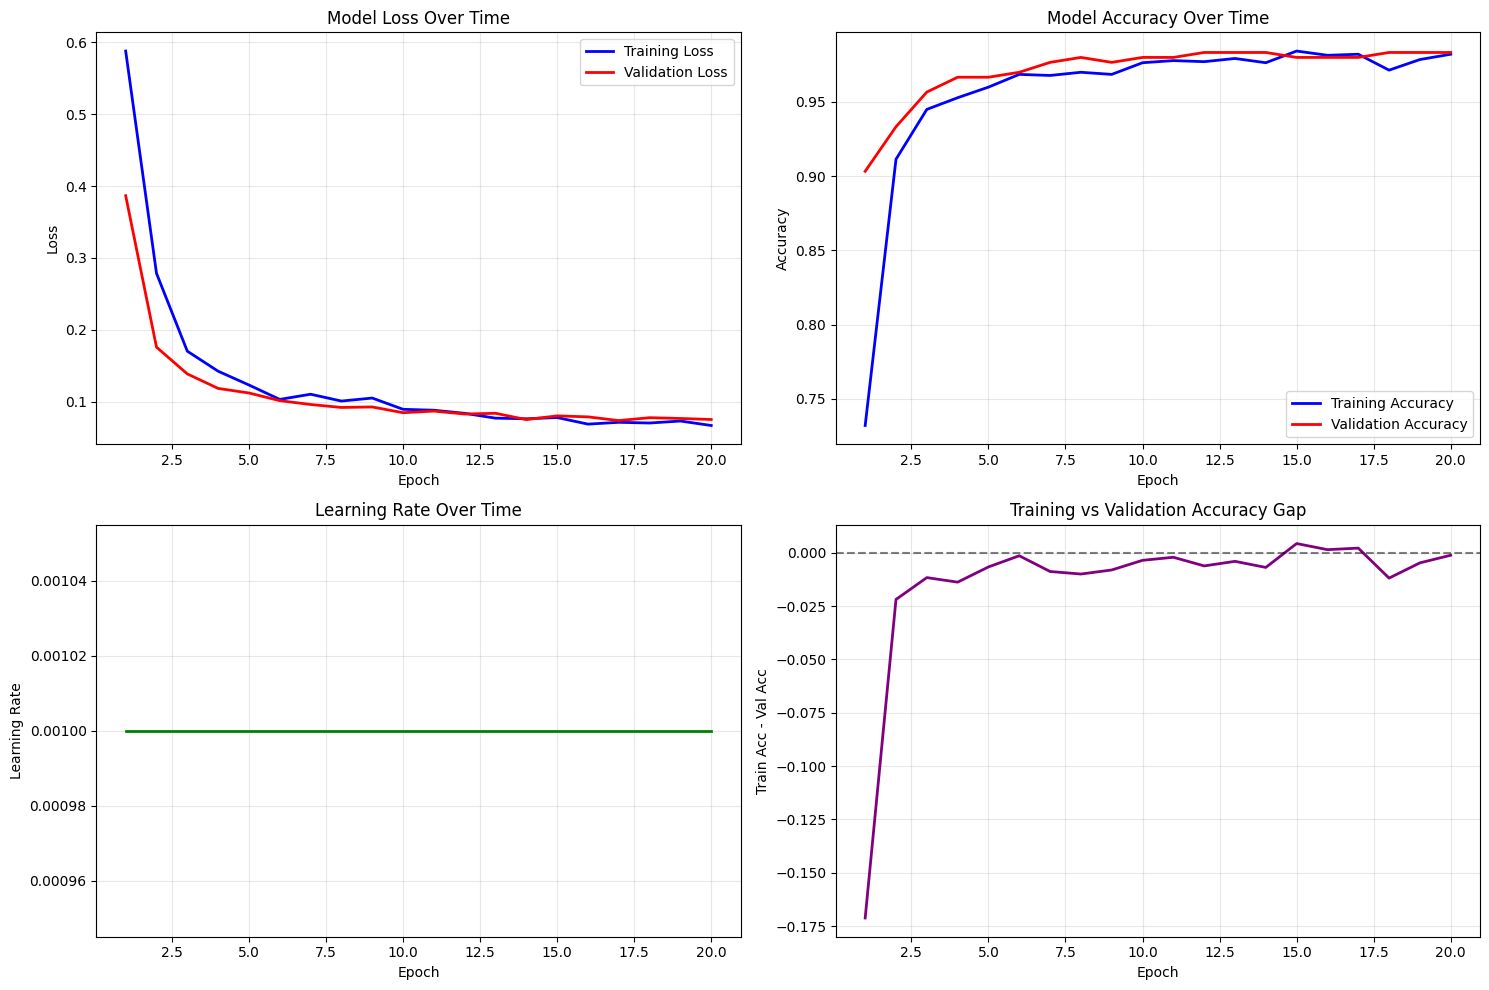

Training Summary:
  Final Training Loss: 0.0669
  Final Validation Loss: 0.0753
  Final Training Accuracy: 0.9821
  Final Validation Accuracy: 0.9833
  Best Validation Accuracy: 0.9833
  Total Epochs: 20


In [9]:
def plot_training_history(history):
    """
    Plot comprehensive training history.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss plot
    axes[0, 0].plot(
        epochs, history["train_loss"], "b-", label="Training Loss", linewidth=2
    )
    axes[0, 0].plot(
        epochs, history["val_loss"], "r-", label="Validation Loss", linewidth=2
    )
    axes[0, 0].set_title("Model Loss Over Time")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0, 1].plot(
        epochs, history["train_acc"], "b-", label="Training Accuracy", linewidth=2
    )
    axes[0, 1].plot(
        epochs, history["val_acc"], "r-", label="Validation Accuracy", linewidth=2
    )
    axes[0, 1].set_title("Model Accuracy Over Time")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Accuracy")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate plot
    axes[1, 0].plot(epochs, history["learning_rates"], "g-", linewidth=2)
    axes[1, 0].set_title("Learning Rate Over Time")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Learning Rate")
    axes[1, 0].grid(True, alpha=0.3)

    # Overfitting detection
    train_val_diff = np.array(history["train_acc"]) - np.array(history["val_acc"])
    axes[1, 1].plot(epochs, train_val_diff, "purple", linewidth=2)
    axes[1, 1].axhline(y=0, color="black", linestyle="--", alpha=0.5)
    axes[1, 1].set_title("Training vs Validation Accuracy Gap")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Train Acc - Val Acc")
    axes[1, 1].grid(True, alpha=0.3)

    # Add annotations
    if len(train_val_diff) > 0:
        max_gap = np.max(train_val_diff)
        if max_gap > 0.1:
            axes[1, 1].text(
                0.5,
                0.9,
                "Potential Overfitting Detected!",
                transform=axes[1, 1].transAxes,
                bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.7),
                horizontalalignment="center",
            )

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("Training Summary:")
    print(f"  Final Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"  Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Final Training Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"  Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"  Best Validation Accuracy: {max(history['val_acc']):.4f}")
    print(f"  Total Epochs: {len(history['train_loss'])}")


# Plot training history
plot_training_history(history)

## Model Evaluation

Let's create a comprehensive evaluation framework:



Validation Evaluation Results:
----------------------------------------
  Loss: 0.0829
  Accuracy: 0.9833
  Precision: 0.9834
  Recall: 0.9833
  F1-Score: 0.9833

Test Evaluation Results:
----------------------------------------
  Loss: 0.0585
  Accuracy: 0.9833
  Precision: 0.9835
  Recall: 0.9833
  F1-Score: 0.9833


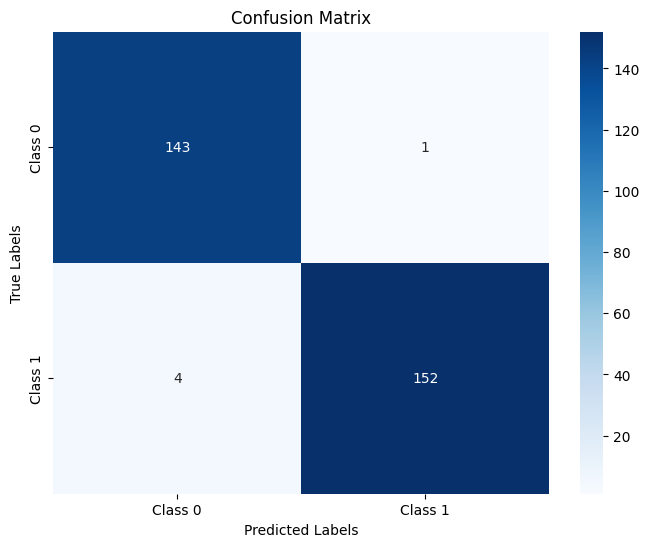

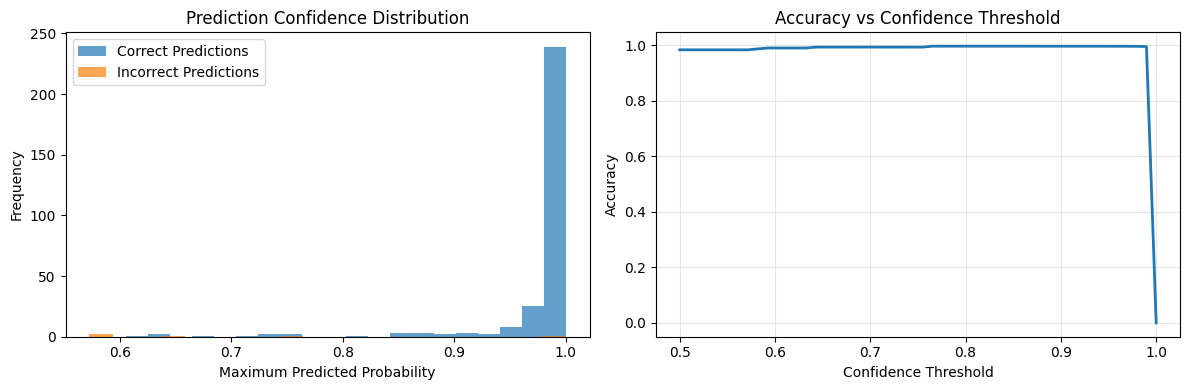

In [10]:
class ModelEvaluator:
    """
    Comprehensive model evaluation class.
    """

    def __init__(self, model, device):
        self.model = model
        self.device = device

    def evaluate_on_loader(self, data_loader, dataset_name="Dataset"):
        """
        Evaluate model on a data loader.
        """
        self.model.eval()

        all_predictions = []
        all_targets = []
        all_probabilities = []
        total_loss = 0.0

        criterion = nn.CrossEntropyLoss()

        with torch.inference_mode():
            for data, targets in data_loader:
                data, targets = data.to(self.device), targets.to(self.device)

                outputs = self.model(data)
                loss = criterion(outputs, targets)

                # Get predictions and probabilities
                probabilities = F.softmax(outputs, dim=1)
                _, predictions = torch.max(outputs, 1)

                # Store results
                all_predictions.extend(predictions.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())
                total_loss += loss.item()

        # Calculate metrics
        avg_loss = total_loss / len(data_loader)
        accuracy = accuracy_score(all_targets, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_targets, all_predictions, average="weighted"
        )

        results = {
            "loss": avg_loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "predictions": all_predictions,
            "targets": all_targets,
            "probabilities": all_probabilities,
        }

        # Print results
        print(f"\n{dataset_name} Evaluation Results:")
        print("-" * 40)
        print(f"  Loss: {avg_loss:.4f}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")

        return results

    def plot_confusion_matrix(self, targets, predictions, class_names=None):
        """
        Plot confusion matrix.
        """
        cm = confusion_matrix(targets, predictions)

        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names or range(len(cm)),
            yticklabels=class_names or range(len(cm)),
        )
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

        return cm

    def plot_prediction_confidence(self, probabilities, targets, predictions):
        """
        Plot prediction confidence distribution.
        """
        probabilities = np.array(probabilities)
        max_probs = np.max(probabilities, axis=1)

        correct_mask = np.array(targets) == np.array(predictions)

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.hist(
            max_probs[correct_mask], alpha=0.7, label="Correct Predictions", bins=20
        )
        plt.hist(
            max_probs[~correct_mask], alpha=0.7, label="Incorrect Predictions", bins=20
        )
        plt.xlabel("Maximum Predicted Probability")
        plt.ylabel("Frequency")
        plt.title("Prediction Confidence Distribution")
        plt.legend()

        plt.subplot(1, 2, 2)
        confidence_threshold = np.linspace(0.5, 1.0, 50)
        accuracies = []

        for threshold in confidence_threshold:
            high_confidence_mask = max_probs >= threshold
            if np.sum(high_confidence_mask) > 0:
                acc = np.mean(correct_mask[high_confidence_mask])
                accuracies.append(acc)
            else:
                accuracies.append(0)

        plt.plot(confidence_threshold, accuracies, linewidth=2)
        plt.xlabel("Confidence Threshold")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs Confidence Threshold")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# Create evaluator and evaluate on all splits
evaluator = ModelEvaluator(trainer.model, device)

# Evaluate on validation set
val_results = evaluator.evaluate_on_loader(val_loader, "Validation")

# Evaluate on test set
test_results = evaluator.evaluate_on_loader(test_loader, "Test")

# Plot confusion matrix
class_names = ["Class 0", "Class 1"]
cm = evaluator.plot_confusion_matrix(
    test_results["targets"], test_results["predictions"], class_names
)

# Plot prediction confidence
evaluator.plot_prediction_confidence(
    test_results["probabilities"], test_results["targets"], test_results["predictions"]
)

## Model Debugging and Diagnostics

Let's create tools for debugging common training issues:



🔍 TRAINING DIAGNOSTICS
✅ HEALTHY TRAINING:
   Good performance with minimal overfitting


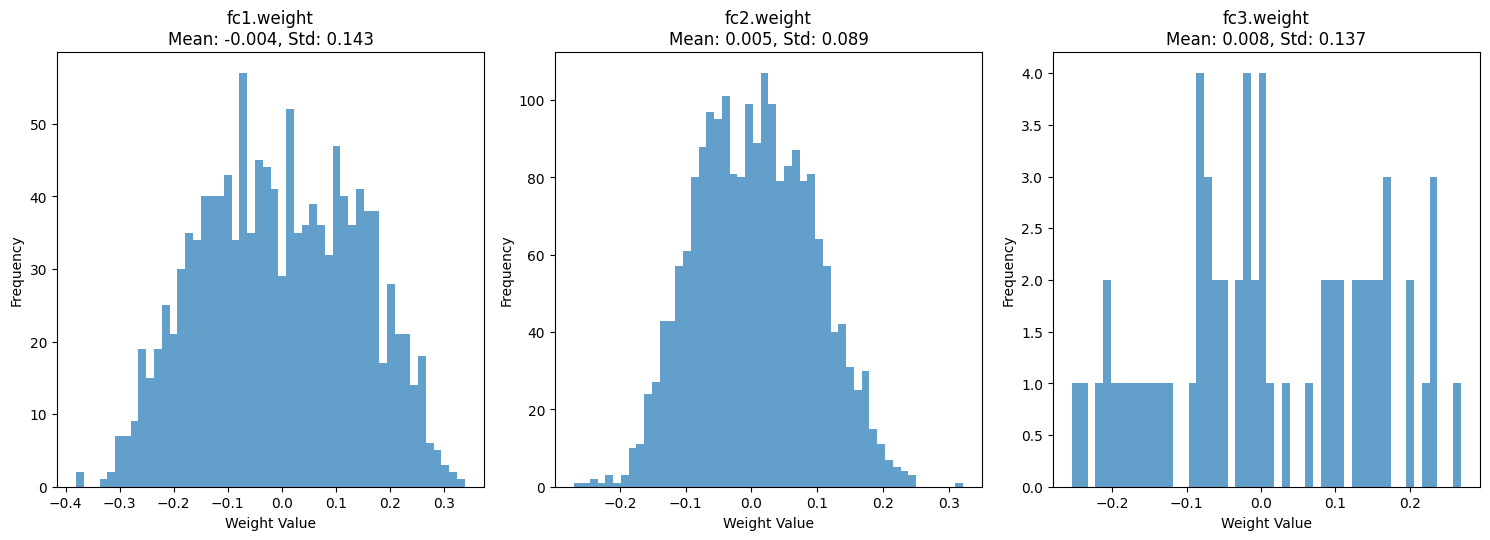


Weight Analysis:
  fc1.weight:
    Mean: -0.003931, Std: 0.143333
    Range: [-0.380248, 0.338776]
  fc2.weight:
    Mean: 0.005436, Std: 0.088756
    Range: [-0.269322, 0.320926]
  fc3.weight:
    Mean: 0.007816, Std: 0.136570
    Range: [-0.253549, 0.267992]


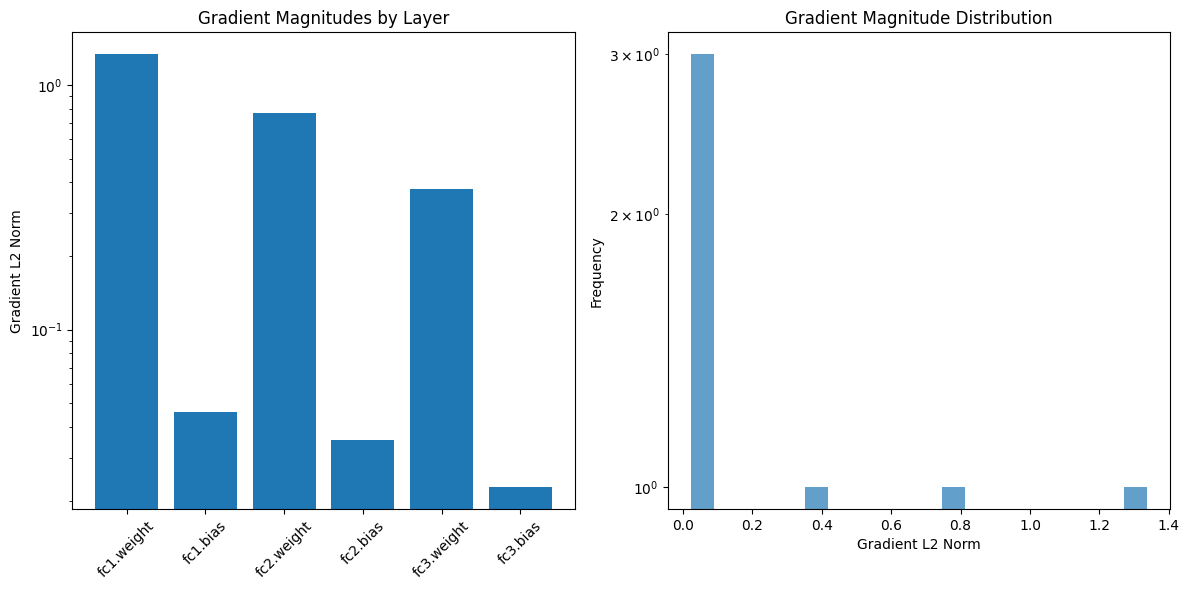


Gradient Analysis:
  Average gradient magnitude: 0.431526
  ✅ Gradient magnitudes appear normal


In [11]:
class ModelDiagnostics:
    """
    Tools for diagnosing model training issues.
    """

    @staticmethod
    def analyze_gradients(model):
        """
        Analyze gradient magnitudes to detect vanishing/exploding gradients.
        """
        gradients = []
        layer_names = []

        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.data.norm(2).item()
                gradients.append(grad_norm)
                layer_names.append(name)

        # Plot gradient magnitudes
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.bar(range(len(gradients)), gradients)
        plt.xticks(range(len(gradients)), layer_names, rotation=45)
        plt.ylabel("Gradient L2 Norm")
        plt.title("Gradient Magnitudes by Layer")
        plt.yscale("log")

        plt.subplot(1, 2, 2)
        plt.hist(gradients, bins=20, alpha=0.7)
        plt.xlabel("Gradient L2 Norm")
        plt.ylabel("Frequency")
        plt.title("Gradient Magnitude Distribution")
        plt.yscale("log")

        plt.tight_layout()
        plt.show()

        # Diagnostic messages
        avg_grad = np.mean(gradients)
        print(f"\nGradient Analysis:")
        print(f"  Average gradient magnitude: {avg_grad:.6f}")

        if avg_grad < 1e-7:
            print(
                "  ⚠️  Very small gradients detected - possible vanishing gradient problem"
            )
        elif avg_grad > 10:
            print("  ⚠️  Large gradients detected - possible exploding gradient problem")
        else:
            print("  ✅ Gradient magnitudes appear normal")

        return gradients, layer_names

    @staticmethod
    def analyze_weights(model):
        """
        Analyze weight distributions.
        """
        weight_stats = []

        plt.figure(figsize=(15, 10))

        subplot_idx = 1
        for name, param in model.named_parameters():
            if "weight" in name and param.dim() > 1:  # Only analyze weight matrices
                weights = param.data.cpu().numpy().flatten()

                stats = {
                    "name": name,
                    "mean": np.mean(weights),
                    "std": np.std(weights),
                    "min": np.min(weights),
                    "max": np.max(weights),
                }
                weight_stats.append(stats)

                # Plot weight distribution
                plt.subplot(2, 3, subplot_idx)
                plt.hist(weights, bins=50, alpha=0.7)
                plt.title(f'{name}\nMean: {stats["mean"]:.3f}, Std: {stats["std"]:.3f}')
                plt.xlabel("Weight Value")
                plt.ylabel("Frequency")

                subplot_idx += 1
                if subplot_idx > 6:  # Limit to 6 subplots
                    break

        plt.tight_layout()
        plt.show()

        # Print weight statistics
        print("\nWeight Analysis:")
        for stats in weight_stats:
            print(f"  {stats['name']}:")
            print(f"    Mean: {stats['mean']:.6f}, Std: {stats['std']:.6f}")
            print(f"    Range: [{stats['min']:.6f}, {stats['max']:.6f}]")

        return weight_stats

    @staticmethod
    def diagnose_training_issues(history):
        """
        Diagnose common training issues from training history.
        """
        print("\n🔍 TRAINING DIAGNOSTICS")
        print("=" * 40)

        train_loss = history["train_loss"]
        val_loss = history["val_loss"]
        train_acc = history["train_acc"]
        val_acc = history["val_acc"]

        # Check for overfitting
        if len(train_loss) > 5:
            recent_train_loss = np.mean(train_loss[-5:])
            recent_val_loss = np.mean(val_loss[-5:])

            if recent_val_loss > recent_train_loss * 1.2:
                print("⚠️  OVERFITTING DETECTED:")
                print("   Validation loss is significantly higher than training loss")
                print("   Suggestions:")
                print("   • Add more regularization (dropout, weight decay)")
                print("   • Reduce model complexity")
                print("   • Get more training data")
                print("   • Use early stopping")

        # Check for underfitting
        if train_acc[-1] < 0.8 and val_acc[-1] < 0.8:
            print("⚠️  UNDERFITTING DETECTED:")
            print("   Both training and validation accuracy are low")
            print("   Suggestions:")
            print("   • Increase model complexity")
            print("   • Reduce regularization")
            print("   • Train for more epochs")
            print("   • Increase learning rate")

        # Check learning rate
        if len(train_loss) > 10:
            early_loss = np.mean(train_loss[:5])
            recent_loss = np.mean(train_loss[-5:])
            improvement = (early_loss - recent_loss) / early_loss

            if improvement < 0.1:
                print("⚠️  SLOW CONVERGENCE:")
                print("   Loss is not decreasing significantly")
                print("   Suggestions:")
                print("   • Increase learning rate")
                print("   • Use a different optimizer (try Adam if using SGD)")
                print("   • Check data preprocessing")

        # Check for training instability
        loss_variance = np.var(train_loss[-10:]) if len(train_loss) >= 10 else 0
        if loss_variance > 0.1:
            print("⚠️  TRAINING INSTABILITY:")
            print("   Training loss is very noisy")
            print("   Suggestions:")
            print("   • Reduce learning rate")
            print("   • Use gradient clipping")
            print("   • Increase batch size")
            print("   • Use learning rate scheduling")

        # Positive feedback
        if (
            train_acc[-1] > 0.85
            and val_acc[-1] > 0.8
            and abs(train_acc[-1] - val_acc[-1]) < 0.1
        ):
            print("✅ HEALTHY TRAINING:")
            print("   Good performance with minimal overfitting")


# Perform diagnostics
diagnostics = ModelDiagnostics()

# Analyze training history
diagnostics.diagnose_training_issues(history)

# Analyze current model weights
weight_stats = diagnostics.analyze_weights(trainer.model)

# To analyze gradients, we need to do a forward and backward pass
trainer.model.train()
sample_batch = next(iter(train_loader))
data, targets = sample_batch[0].to(device), sample_batch[1].to(device)

outputs = trainer.model(data)
loss = nn.CrossEntropyLoss()(outputs, targets)
loss.backward()

gradient_info = diagnostics.analyze_gradients(trainer.model)

## Advanced Training Techniques

Let's demonstrate some advanced training techniques:



🎯 DEMONSTRATING LEARNING RATE SCHEDULING
Epoch 1: Train Loss: 0.2573, Val Loss: 0.1571, LR: 0.010000
Epoch 2: Train Loss: 0.1353, Val Loss: 0.1181, LR: 0.010000
Epoch 3: Train Loss: 0.1142, Val Loss: 0.0972, LR: 0.010000
Epoch 4: Train Loss: 0.1026, Val Loss: 0.1314, LR: 0.010000
Epoch 5: Train Loss: 0.0858, Val Loss: 0.1461, LR: 0.010000
Epoch 6: Train Loss: 0.0911, Val Loss: 0.1079, LR: 0.010000
Epoch 7: Train Loss: 0.0885, Val Loss: 0.1012, LR: 0.005000
Epoch 8: Train Loss: 0.0757, Val Loss: 0.0948, LR: 0.005000
Epoch 9: Train Loss: 0.0614, Val Loss: 0.1029, LR: 0.005000
Epoch 10: Train Loss: 0.0640, Val Loss: 0.0919, LR: 0.005000
Epoch 11: Train Loss: 0.0483, Val Loss: 0.1097, LR: 0.005000
Epoch 12: Train Loss: 0.0399, Val Loss: 0.1111, LR: 0.005000
Epoch 13: Train Loss: 0.0403, Val Loss: 0.1177, LR: 0.005000
Epoch 14: Train Loss: 0.0589, Val Loss: 0.1151, LR: 0.002500
Epoch 15: Train Loss: 0.0438, Val Loss: 0.1020, LR: 0.002500
Epoch 16: Train Loss: 0.0396, Val Loss: 0.1027, LR: 

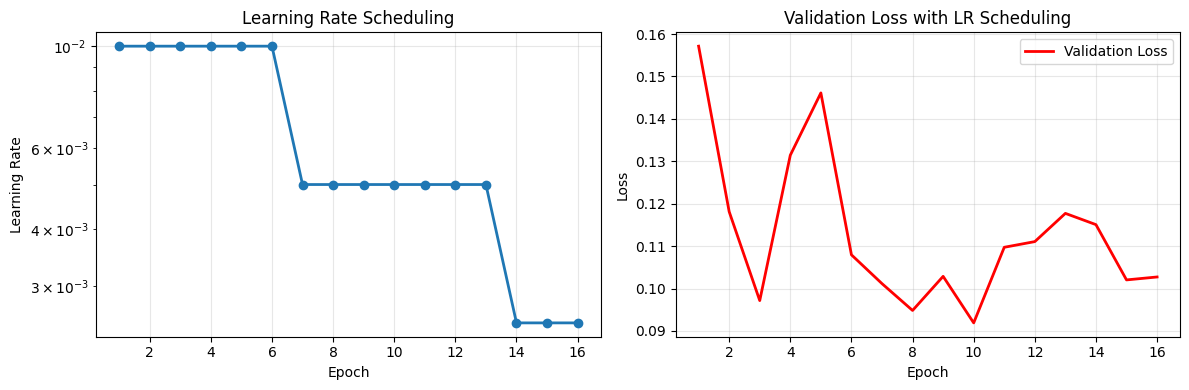


✂️  DEMONSTRATING GRADIENT CLIPPING
Training with gradient clipping (max_grad_norm=1.0)...
Epoch 1: Train Loss: 0.3853, Val Loss: 0.1713
Epoch 2: Train Loss: 0.2001, Val Loss: 0.1727
Epoch 3: Train Loss: 0.1593, Val Loss: 0.1455
Epoch 4: Train Loss: 0.1466, Val Loss: 0.1500
Epoch 5: Train Loss: 0.1391, Val Loss: 0.1220


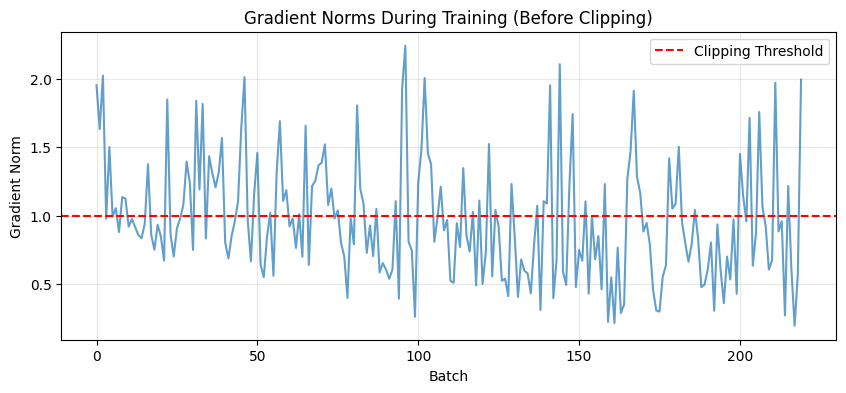


Gradient Statistics:
  Mean gradient norm: 0.9665
  Max gradient norm: 2.2433
  Batches with clipped gradients: 86


In [13]:
# Learning Rate Scheduling Example
def demonstrate_lr_scheduling():
    """
    Demonstrate training with learning rate scheduling.
    """
    print("\n🎯 DEMONSTRATING LEARNING RATE SCHEDULING")
    print("=" * 50)

    # Create a new model for this demonstration
    model_scheduled = SimpleClassifier(input_size=20, hidden_size=64, num_classes=2)
    optimizer_scheduled = optim.Adam(
        model_scheduled.parameters(), lr=0.01
    )  # Higher initial LR

    # Create learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_scheduled, mode="min", factor=0.5, patience=3
    )

    # Modified trainer with scheduler
    class ScheduledTrainer(Trainer):
        def __init__(
            self,
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            scheduler,
            device,
        ):
            super().__init__(
                model, train_loader, val_loader, criterion, optimizer, device
            )
            self.scheduler = scheduler

        def train(self, num_epochs, **kwargs):
            # Call parent train method but override scheduler logic
            for epoch in range(num_epochs):
                train_loss, train_acc = self.train_epoch()
                val_loss, val_acc = self.validate_epoch()

                # Update scheduler with validation loss
                self.scheduler.step(val_loss)

                # Record metrics
                self.history["train_loss"].append(train_loss)
                self.history["train_acc"].append(train_acc)
                self.history["val_loss"].append(val_loss)
                self.history["val_acc"].append(val_acc)
                self.history["learning_rates"].append(
                    self.optimizer.param_groups[0]["lr"]
                )

                print(
                    f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, "
                    f"Val Loss: {val_loss:.4f}, LR: {self.optimizer.param_groups[0]['lr']:.6f}"
                )

                if epoch >= 15:  # Stop early for demo
                    break

            return self.history

    # Train with scheduler
    scheduled_trainer = ScheduledTrainer(
        model_scheduled,
        train_loader,
        val_loader,
        nn.CrossEntropyLoss(),
        optimizer_scheduled,
        scheduler,
        device,
    )

    scheduled_history = scheduled_trainer.train(20)

    # Plot learning rate changes
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    epochs = range(1, len(scheduled_history["learning_rates"]) + 1)
    plt.plot(
        epochs, scheduled_history["learning_rates"], "o-", linewidth=2, markersize=6
    )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Scheduling")
    plt.yscale("log")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(
        epochs,
        scheduled_history["val_loss"],
        "r-",
        linewidth=2,
        label="Validation Loss",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss with LR Scheduling")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Gradient Clipping Example
def demonstrate_gradient_clipping():
    """
    Demonstrate gradient clipping to prevent exploding gradients.
    """
    print("\n✂️  DEMONSTRATING GRADIENT CLIPPING")
    print("=" * 50)

    model_clipped = SimpleClassifier(input_size=20, hidden_size=64, num_classes=2)
    optimizer_clipped = optim.SGD(
        model_clipped.parameters(), lr=0.1
    )  # High LR to cause issues

    class ClippedTrainer(Trainer):
        def __init__(
            self,
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            device,
            max_grad_norm=1.0,
        ):
            super().__init__(
                model, train_loader, val_loader, criterion, optimizer, device
            )
            self.max_grad_norm = max_grad_norm
            self.grad_norms = []

        def train_epoch(self):
            self.model.train()
            total_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            for batch_idx, (data, targets) in enumerate(self.train_loader):
                data, targets = data.to(self.device), targets.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, targets)
                loss.backward()

                # Calculate gradient norm before clipping
                total_norm = 0
                for p in self.model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** (1.0 / 2)
                self.grad_norms.append(total_norm)

                # Apply gradient clipping
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(), self.max_grad_norm
                )

                self.optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_samples += targets.size(0)
                correct_predictions += (predicted == targets).sum().item()

            avg_loss = total_loss / len(self.train_loader)
            accuracy = correct_predictions / total_samples
            return avg_loss, accuracy

    # Train with gradient clipping
    clipped_trainer = ClippedTrainer(
        model_clipped,
        train_loader,
        val_loader,
        nn.CrossEntropyLoss(),
        optimizer_clipped,
        device,
        max_grad_norm=1.0,
    )

    print("Training with gradient clipping (max_grad_norm=1.0)...")
    for epoch in range(5):  # Just a few epochs for demo
        train_loss, train_acc = clipped_trainer.train_epoch()
        val_loss, val_acc = clipped_trainer.validate_epoch()
        print(
            f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

    # Plot gradient norms
    plt.figure(figsize=(10, 4))
    plt.plot(clipped_trainer.grad_norms, alpha=0.7)
    plt.axhline(y=1.0, color="red", linestyle="--", label="Clipping Threshold")
    plt.xlabel("Batch")
    plt.ylabel("Gradient Norm")
    plt.title("Gradient Norms During Training (Before Clipping)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"\nGradient Statistics:")
    print(f"  Mean gradient norm: {np.mean(clipped_trainer.grad_norms):.4f}")
    print(f"  Max gradient norm: {np.max(clipped_trainer.grad_norms):.4f}")
    print(
        f"  Batches with clipped gradients: {np.sum(np.array(clipped_trainer.grad_norms) > 1.0)}"
    )


# Run demonstrations
demonstrate_lr_scheduling()
demonstrate_gradient_clipping()

## Summary

In this comprehensive notebook, you've learned essential patterns for training and evaluating PyTorch models:

### Key Components of Robust Training:

**1. Structured Training Loop:**

- Separate training and validation phases
- Proper model state management (`train()` / `eval()`)
- Gradient zeroing and parameter updates
- Metric tracking and history

**2. Model Evaluation:**

- Comprehensive metrics (accuracy, precision, recall, F1)
- Confusion matrices and error analysis
- Prediction confidence analysis
- Proper use of `torch.inference_mode()`

**3. Training Monitoring:**

- Learning curves visualization
- Overfitting detection
- Performance tracking
- Early stopping mechanisms

**4. Model Persistence:**

- Checkpointing best models
- Saving and loading model states
- Training resumption capabilities

**5. Debugging and Diagnostics:**

- Gradient analysis
- Weight distribution monitoring
- Training issue identification
- Performance bottleneck detection

**6. Advanced Techniques:**

- Learning rate scheduling
- Gradient clipping
- Regularization strategies

### Best Practices Summary:

✅ **Do:**

- Always use separate train/validation/test splits
- Monitor both training and validation metrics
- Save best models based on validation performance
- Use early stopping to prevent overfitting
- Visualize training progress
- Set random seeds for reproducibility

❌ **Don't:**

- Train without validation
- Ignore overfitting signals
- Forget to set model to eval mode during inference
- Skip gradient zeroing
- Evaluate on training data only

### What's Next?

With these solid training and evaluation patterns, you're ready to:

- Apply these techniques to real-world datasets
- Experiment with different architectures
- Implement more advanced training strategies
- Move on to specialized domains (computer vision, NLP, etc.)

Remember: Good training practices are just as important as good model architecture!
